<a href="https://colab.research.google.com/github/sidsanc/258_DeepLearningAssignment/blob/main/Assignment_7/Build_vision_classifier1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_sample_images
import tensorflow as tf
from tensorflow import keras
import tensorflow_hub as hub
import tensorflow_datasets as tfds
from functools import partial
from tensorflow.keras.applications import EfficientNetB0

In [ ]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
    print("Device:", tpu.master())
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError:
    print("Not connected to a TPU runtime. Using CPU/GPU strategy")
    strategy = tf.distribute.MirroredStrategy()

Not connected to a TPU runtime. Using CPU/GPU strategy


In [ ]:
# Load data

(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.cifar10.load_data()

170498071/170498071 [==============================] - 3s 0us/step


In [ ]:
# Split train into train and valid
X_train, X_valid = X_train_full[:-10000], X_train_full[-10000:]
y_train, y_valid = y_train_full[:-10000], y_train_full[-10000:]

In [ ]:
tf.random.set_seed(42)

In [ ]:
X_train.shape, X_valid.shape, X_test.shape, y_train.shape

((40000, 32, 32, 3), (10000, 32, 32, 3), (10000, 32, 32, 3), (40000, 1))

## Convolution Layers

In [ ]:
images = load_sample_images()["images"]
images = tf.keras.layers.CenterCrop(height=70, width=120)(images)
images = tf.keras.layers.Rescaling(scale=1 / 255)(images)

In [ ]:
images.shape

TensorShape([2, 70, 120, 3])

In [ ]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
conv_layer = tf.keras.layers.Conv2D(filters=32, kernel_size=7)
fmaps = conv_layer(images)

In [ ]:
fmaps.shape

TensorShape([2, 64, 114, 32])

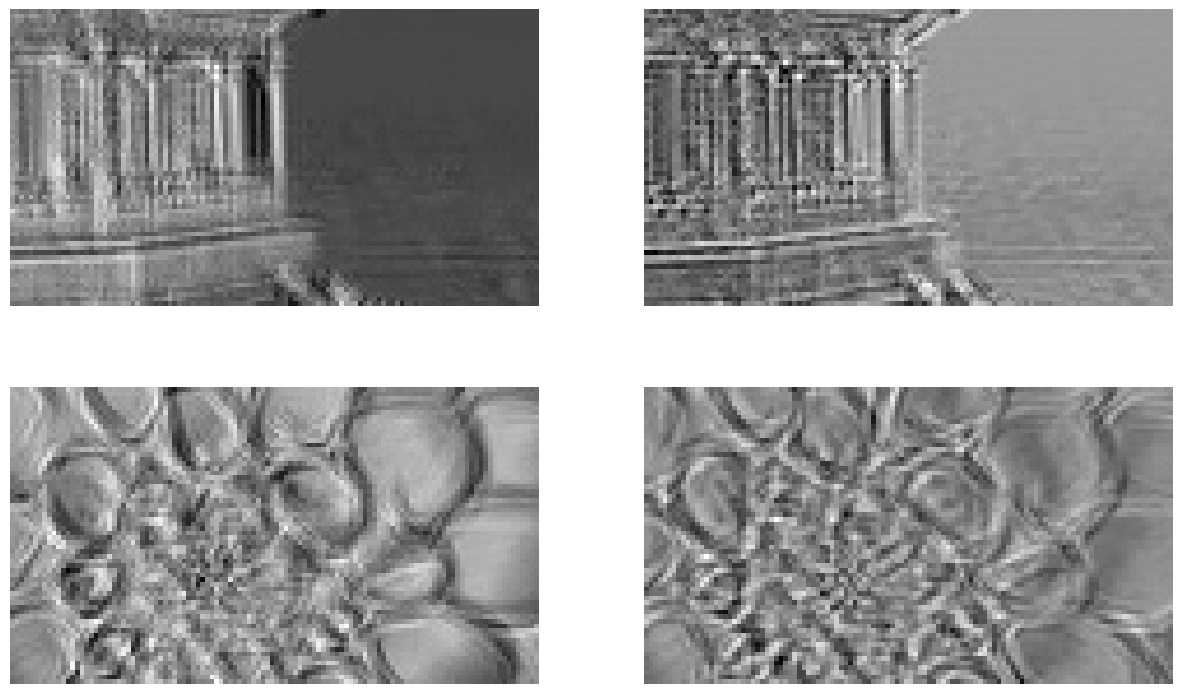

In [ ]:
plt.figure(figsize=(15, 9))
for image_idx in (0, 1):
    for fmap_idx in (0, 1):
        plt.subplot(2, 2, image_idx * 2 + fmap_idx + 1)
        plt.imshow(fmaps[image_idx, :, :, fmap_idx], cmap="gray")
        plt.axis("off")

plt.show()

In [ ]:
conv_layer = tf.keras.layers.Conv2D(filters=32, kernel_size=7,
                                    padding="same")
fmaps = conv_layer(images)

In [ ]:
fmaps.shape

TensorShape([2, 70, 120, 32])

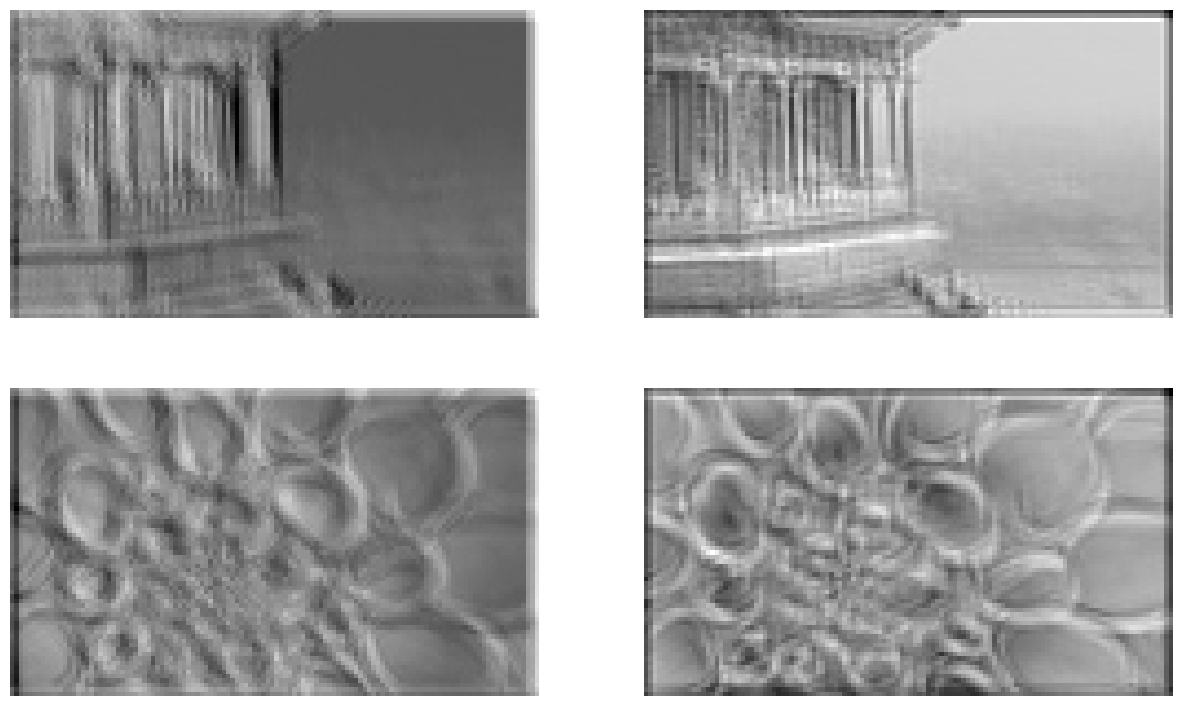

In [ ]:
plt.figure(figsize=(15, 9))
for image_idx in (0, 1):
    for fmap_idx in (0, 1):
        plt.subplot(2, 2, image_idx * 2 + fmap_idx + 1)
        plt.imshow(fmaps[image_idx, :, :, fmap_idx], cmap="gray")
        plt.axis("off")

plt.show()

In [ ]:
# extra code – shows that the output shape when we set strides=2
conv_layer = tf.keras.layers.Conv2D(filters=32, kernel_size=7, padding="same",
                                    strides=2)
fmaps = conv_layer(images)
fmaps.shape

TensorShape([2, 35, 60, 32])

In [ ]:
# extra code – this utility function can be useful to compute the size of the
#              feature maps output by a convolutional layer. It also returns
#              the number of ignored rows or columns if padding="valid", or the
#              number of zero-padded rows or columns if padding="same"."""

import numpy as np

def conv_output_size(input_size, kernel_size, strides=1, padding="valid"):
    if padding=="valid":
        z = input_size - kernel_size + strides
        output_size = z // strides
        num_ignored = z % strides
        return output_size, num_ignored
    else:
        output_size = (input_size - 1) // strides + 1
        num_padded = (output_size - 1) * strides + kernel_size - input_size
        return output_size, num_padded

conv_output_size(np.array([70, 120]), kernel_size=7, strides=2, padding="same")

(array([35, 60]), array([5, 5]))

In [ ]:
kernels, biases = conv_layer.get_weights()

In [ ]:
print('Kernel shape:', kernels.shape)
print('Bias shape:', biases.shape)

Kernel shape: (7, 7, 3, 32)
Bias shape: (32,)


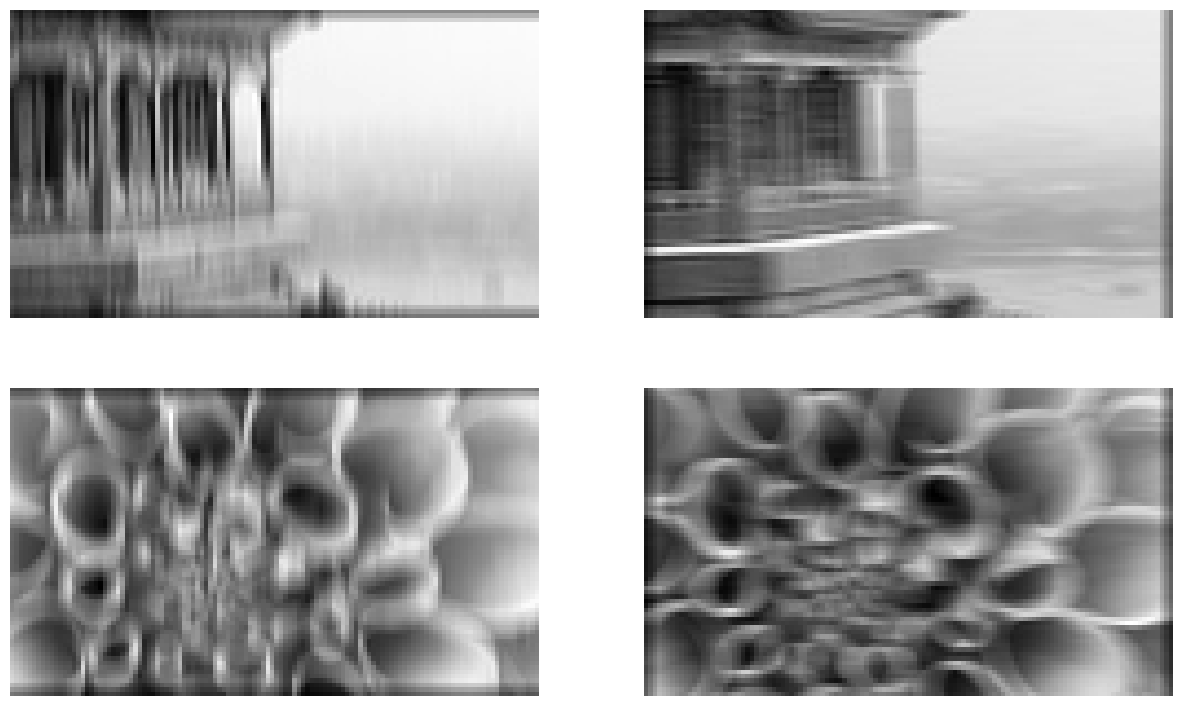

In [ ]:
plt.figure(figsize=(15, 9))

filters = np.zeros([7, 7, 3, 2])
filters[:, 3, :, 0] = 1
filters[3, :, :, 1] = 1

biases = tf.zeros([2])

fmaps = tf.nn.conv2d(images, filters, strides=1, padding="SAME") + biases

for image_idx in (0, 1):
    for fmap_idx in (0, 1):
        plt.subplot(2, 2, image_idx * 2 + fmap_idx + 1)
        plt.imshow(fmaps[image_idx, :, :, fmap_idx], cmap="gray")
        plt.axis("off")

plt.show()

## Pooling Layers with Keras

**Depth Wise Pooling**

In [ ]:

fmaps = np.random.rand(2, 70, 120, 60)

output = tf.nn.max_pool(fmaps, ksize=(1, 1, 1, 3), strides=(1, 1, 1, 3),
                        padding="VALID")
output.shape

TensorShape([2, 70, 120, 20])

In [ ]:
class DepthPool(tf.keras.layers.Layer):
    def __init__(self, pool_size=2, **kwargs):
        super().__init__(**kwargs)
        self.pool_size = pool_size
    
    def call(self, inputs):
        shape = tf.shape(inputs)  
        groups = shape[-1] // self.pool_size  
        new_shape = tf.concat([shape[:-1], [groups, self.pool_size]], axis=0)
        return tf.reduce_max(tf.reshape(inputs, new_shape), axis=-1)

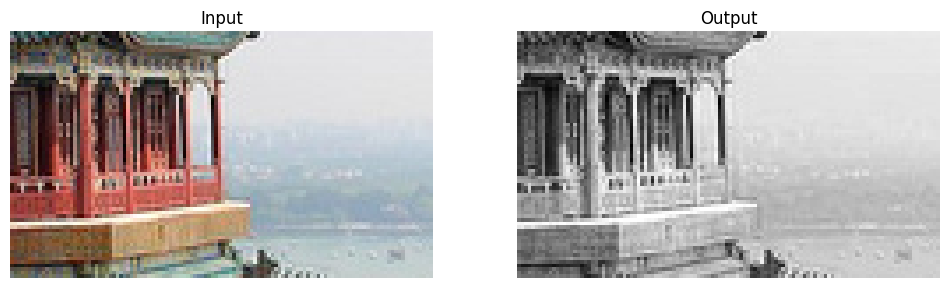

In [ ]:

depth_output = DepthPool(pool_size=3)(images)

plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.title("Input")
plt.imshow(images[0])  # plot the 1st image
plt.axis("off")
plt.subplot(1, 2, 2)
plt.title("Output")
plt.imshow(depth_output[0, ..., 0], cmap="gray")  # plot 1st image's output
plt.axis("off")
plt.show()

# Cifar10

## Simple CNN

In [ ]:
model = tf.keras.models.Sequential([
    keras.layers.Conv2D(filters=32,kernel_size=3,padding="same", activation="relu", input_shape=[32,32,3]),
    keras.layers.Conv2D(filters=32,kernel_size=3,padding="same", activation="relu"),
    keras.layers.MaxPool2D(pool_size=2,strides=2,padding='valid'),
    keras.layers.Conv2D(filters=64,kernel_size=3,padding="same", activation="relu"),
    keras.layers.Conv2D(filters=64,kernel_size=3,padding="same", activation="relu"),
    keras.layers.MaxPool2D(pool_size=2,strides=2,padding='valid'),
    keras.layers.Flatten(),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=128,activation='relu'),
    keras.layers.Dense(units=10,activation='softmax')
])

In [ ]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])

history = model.fit(X_train, y_train, epochs=3, validation_data=(X_valid, y_valid))

score = model.evaluate(X_test, y_test)

Epoch 1/3
1250/1250 [==============================] - 26s 8ms/step - loss: 1.7947 - accuracy: 0.4081 - val_loss: 1.3409 - val_accuracy: 0.5098
Epoch 2/3
1250/1250 [==============================] - 9s 7ms/step - loss: 1.2651 - accuracy: 0.5493 - val_loss: 1.0842 - val_accuracy: 0.6256
Epoch 3/3
313/313 [==============================] - 1s 3ms/step - loss: 0.9884 - accuracy: 0.6607


In [ ]:
# predict on test images

X_test_samples = X_test[:10] 
y_pred = model.predict(X_test_samples)

1/1 [==============================] - 0s 205ms/step


## LeNet-5


In [ ]:
model = keras.models.Sequential()
model.add(keras.layers.Conv2D(filters=32, kernel_size=(5,5), padding='same', activation='relu', input_shape=(32, 32, 3)))
model.add(keras.layers.MaxPool2D(strides=2))
model.add(keras.layers.Conv2D(filters=48, kernel_size=(5,5), padding='valid', activation='relu'))
model.add(keras.layers.MaxPool2D(strides=2))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(256, activation='relu'))
model.add(keras.layers.Dense(84, activation='relu'))
model.add(keras.layers.Dense(10, activation='softmax'))

In [ ]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

history = model.fit(X_train, y_train, epochs=3, validation_data=(X_valid, y_valid))

Epoch 1/3
1250/1250 [==============================] - 8s 4ms/step - loss: 2.0509 - accuracy: 0.3023 - val_loss: 1.6206 - val_accuracy: 0.4245
Epoch 2/3
1250/1250 [==============================] - 7s 5ms/step - loss: 1.5070 - accuracy: 0.4631 - val_loss: 1.4041 - val_accuracy: 0.4972
Epoch 3/3
1250/1250 [==============================] - 5s 4ms/step - loss: 1.3534 - accuracy: 0.5222 - val_loss: 1.3887 - val_accuracy: 0.5214


In [ ]:
score = model.evaluate(X_test, y_test)
score

313/313 [==============================] - 2s 6ms/step - loss: 1.3874 - accuracy: 0.5202


[1.3873687982559204, 0.5202000141143799]

## Transfer Learning with Efficient Net

In [ ]:
# Remove last layer
model = EfficientNetB0(include_top=False, weights='imagenet')

16705208/16705208 [==============================] - 2s 0us/step


In [ ]:
IMG_SIZE = 224
BATCH_SIZE = 64
NUM_CLASSES = 10

In [ ]:
# Create TensorFlow Datasets from the NumPy arrays
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))

In [ ]:
# Resize image 

size = (IMG_SIZE, IMG_SIZE)
train_ds = train_ds.map(lambda image, label: (tf.image.resize(image, size), label))
test_ds = test_ds.map(lambda image, label: (tf.image.resize(image, size), label))

In [ ]:
# One-hot / categorical encoding
def input_preprocess(image, label):
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label

# Apply one-hot encoding to the training dataset
train_ds = train_ds.map(input_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.batch(batch_size=BATCH_SIZE, drop_remainder=True)
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)

# Apply one-hot encoding to the test dataset
test_ds = test_ds.map(input_preprocess)
test_ds = test_ds.batch(batch_size=BATCH_SIZE, drop_remainder=True)

In [ ]:
def build_model(num_classes):
    inputs = keras.layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    #x = img_augmentation(inputs)

    # Transfer learning
    model = EfficientNetB0(include_top=False, input_tensor=inputs, weights="imagenet")
    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = keras.layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = keras.layers.BatchNormalization()(x)
    top_dropout_rate = 0.2
    x = keras.layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = keras.layers.Dense(NUM_CLASSES, activation="softmax", name="pred")(x)
    outputs = tf.expand_dims(outputs, axis=1)

    # Compile
    model = tf.keras.Model(inputs, outputs, name="EfficientNet")
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-2), loss="categorical_crossentropy", metrics=["accuracy"])

    return model

In [ ]:
model = build_model(num_classes=NUM_CLASSES)

hist = model.fit(train_ds, epochs=3, validation_data=test_ds, verbose=2)

(None, 1, 10)
Epoch 1/3
625/625 - 93s - loss: 0.8027 - accuracy: 0.8245 - val_loss: 0.5214 - val_accuracy: 0.8677 - 93s/epoch - 148ms/step
Epoch 2/3
625/625 - 82s - loss: 0.4908 - accuracy: 0.8572 - val_loss: 0.3711 - val_accuracy: 0.8816 - 82s/epoch - 131ms/step
Epoch 3/3
625/625 - 81s - loss: 0.4195 - accuracy: 0.8645 - val_loss: 0.3892 - val_accuracy: 0.8756 - 81s/epoch - 130ms/step


## Transfer Learning with BiT

In [ ]:
# Hyperparamters

IMG_SIZE = 384
CROP_TO = 224
BATCH_SIZE = 64
STEPS_PER_EPOCH = 10
AUTO = tf.data.AUTOTUNE  
NUM_CLASSES = 10
SCHEDULE_LENGTH = (20)
SCHEDULE_BOUNDARIES = [5, 10, 15]

In [ ]:
# Create TensorFlow Datasets from the NumPy arrays

train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))

In [ ]:
# Data preprocessing functions

@tf.function
def preprocess_train(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.resize(image, (CROP_TO, CROP_TO))
    image = tf.image.random_crop(image, (CROP_TO, CROP_TO, 3))
    image = image / 255.0
    return (image, label)

@tf.function
def preprocess_test(image, label):
    image = tf.image.resize(image, (CROP_TO, CROP_TO))
    image = image / 255.0
    return (image, label)

DATASET_NUM_TRAIN_EXAMPLES = train_ds.cardinality().numpy()

repeat_count = int(SCHEDULE_LENGTH * BATCH_SIZE / DATASET_NUM_TRAIN_EXAMPLES * STEPS_PER_EPOCH)
repeat_count += 10 + 1

In [ ]:
# Preprocess the training data pipeline
train_ds = train_ds.shuffle(10000)
train_ds = train_ds.repeat(repeat_count)
train_ds = train_ds.map(preprocess_train, num_parallel_calls=AUTO)
train_ds = train_ds.batch(BATCH_SIZE)
train_ds = train_ds.prefetch(AUTO)

# Preprocess the test data pipeline
test_ds = test_ds.map(preprocess_test, num_parallel_calls=AUTO)
test_ds = test_ds.batch(BATCH_SIZE)
test_ds = test_ds.prefetch(AUTO)

In [ ]:
# Load pretrained model

bit_model_url = "https://tfhub.dev/google/bit/m-r50x1/1"
bit_module = hub.KerasLayer(bit_model_url)

In [ ]:
class BiTModel(keras.Model):
  def __init__(self, num_classes, module, **kwargs):
    super().__init__(**kwargs)
    self.num_classes = num_classes
    self.head = keras.layers.Dense(num_classes, kernel_initializer="zeros")
    self.bit_model = module

  def call(self, images):
    bit_embedding = self.bit_model(images)
    return self.head(bit_embedding)

model = BiTModel(num_classes=NUM_CLASSES, module=bit_module)

In [ ]:
# Optimizer and loss

learning_rate = 0.005 * BATCH_SIZE / 512

# Decay learning rate by a factor of 10 at SCHEDULE_BOUNDARIES.
lr_schedule = keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=SCHEDULE_BOUNDARIES,
    values=[
        learning_rate,
        learning_rate * 0.1,
        learning_rate * 0.01,
        learning_rate * 0.001,
    ],
)
optimizer = keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9)

loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [ ]:
model.compile(optimizer=optimizer, loss=loss_fn, metrics=["accuracy"])

In [ ]:
# Early stopping callback

callbacks = [keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=2, restore_best_weights=True)]

In [ ]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    epochs=3,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_data=test_ds,
    callbacks=callbacks,
)

Epoch 1/3
10/10 [==============================] - 86s 10s/step - loss: 0.8217 - accuracy: 0.7000 - val_loss: 0.6816 - val_accuracy: 0.7553
Epoch 2/3
10/10 [==============================] - 86s 10s/step - loss: 0.6968 - accuracy: 0.7563 - val_loss: 0.6228 - val_accuracy: 0.7829
Epoch 3/3
10/10 [==============================] - 86s 9s/step - loss: 0.5830 - accuracy: 0.7969 - val_loss: 0.6009 - val_accuracy: 0.7918


In [ ]:
# Evaluate model

accuracy = model.evaluate(test_ds)[1] * 100
print("Accuracy: {:.2f}%".format(accuracy))

157/157 [==============================] - 61s 389ms/step - loss: 0.6009 - accuracy: 0.7918
Accuracy: 79.18%


## Image augmentation

In [ ]:
# Create TensorFlow Datasets from the NumPy arrays
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))

In [ ]:
train_images = train_ds.map(lambda x, y: x).as_numpy_iterator()
train_labels = train_ds.map(lambda x, y: y).as_numpy_iterator()

/usr/local/lib/python3.10/dist-packages/matplotlib/text.py:1279: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


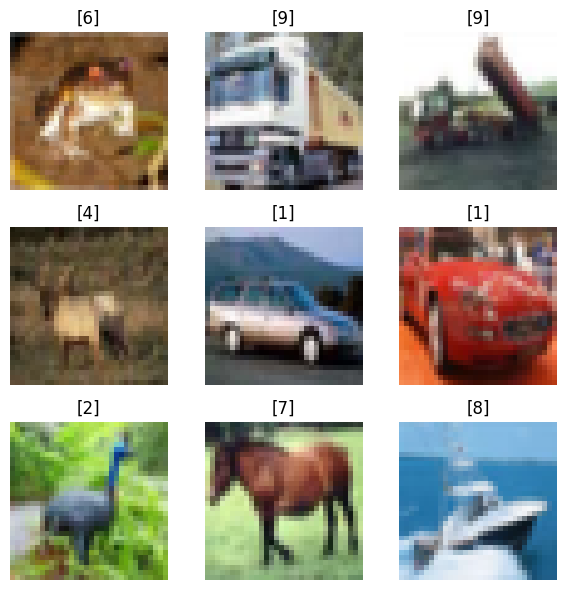

In [ ]:
# Plot 9 images from the train dataset
plt.figure(figsize=(6, 6))
for i, (image, label) in enumerate(zip(train_images, train_labels)):
    if i >= 9:
        break
    plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(label)
    plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
    tf.keras.layers.experimental.preprocessing.RandomFlip(mode="horizontal"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(factor=0.05),
    tf.keras.layers.experimental.preprocessing.RandomContrast(factor=0.2)
])

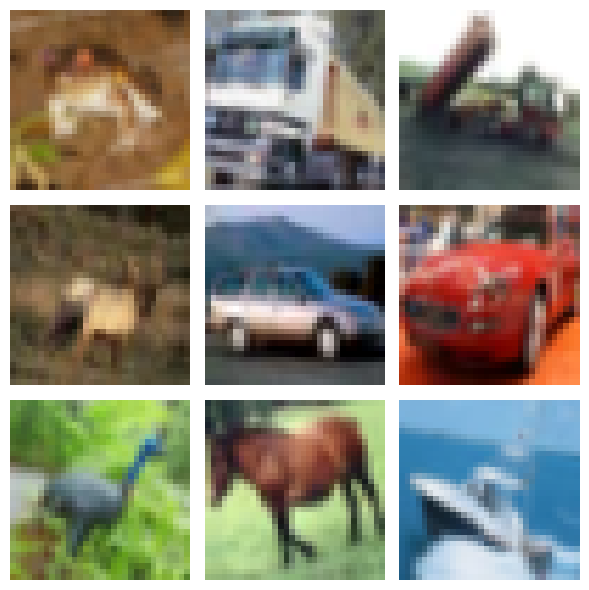

In [ ]:
# Apply data augmentation to a subset of 9 images
augmented_images = []
for image, _ in train_ds.take(9):
    augmented_image = data_augmentation(image)
    augmented_images.append(augmented_image)

# Plot the augmented images
plt.figure(figsize=(6, 6))
for i, image in enumerate(augmented_images):
    plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.axis('off')

plt.tight_layout()
plt.show()

## MLP Mixer

In [ ]:
num_classes = 10
input_shape = (32, 32, 3)

weight_decay = 0.0001
batch_size = 128
num_epochs = 3
dropout_rate = 0.2
image_size = 64  
patch_size = 8  
num_patches = (image_size // patch_size) ** 2 
embedding_dim = 256  
num_blocks = 4  
learning_rate = 0.005

In [ ]:
class Patches(keras.layers.Layer):
  def __init__(self, patch_size, num_patches):
    super().__init__()
    self.patch_size = patch_size
    self.num_patches = num_patches

  def call(self, images):
    batch_size = tf.shape(images)[0]
    patches = tf.image.extract_patches(
        images=images,
        sizes=[1, self.patch_size, self.patch_size, 1],
        strides=[1, self.patch_size, self.patch_size, 1],
        rates=[1, 1, 1, 1],
        padding="VALID",
    )
    patch_dims = patches.shape[-1]
    patches = tf.reshape(patches, [batch_size, self.num_patches, patch_dims])
    return patches

In [ ]:
data_augmentation = keras.Sequential(
    [
        keras.layers.Normalization(),
        keras.layers.Resizing(image_size, image_size),
        keras.layers.RandomFlip("horizontal"),
        keras.layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)
data_augmentation.layers[0].adapt(X_train)

In [ ]:
def build_classifier(blocks, positional_encoding=False):
    inputs = keras.layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size, num_patches)(augmented)
    # Encode patches to generate a [batch_size, num_patches, embedding_dim] tensor.
    x = keras.layers.Dense(units=embedding_dim)(patches)
    if positional_encoding:
        positions = tf.range(start=0, limit=num_patches, delta=1)
        position_embedding = keras.layers.Embedding(
            input_dim=num_patches, output_dim=embedding_dim
        )(positions)
        x = x + position_embedding

    # Process x using the module blocks.
    x = blocks(x)

    representation = keras.layers.GlobalAveragePooling1D()(x)
    representation = keras.layers.Dropout(rate=dropout_rate)(representation)
    logits = keras.layers.Dense(num_classes)(representation)

    return keras.Model(inputs=inputs, outputs=logits)

In [ ]:
def run_experiment(model):
    # Create Adam optimizer with weight decay.
    optimizer = keras.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay,
    )
    # Compile the model.
    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="acc"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top5-acc"),
        ],
    )
    # Create a learning rate scheduler callback.
    reduce_lr = keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=5
    )
    # Create an early stopping callback.
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=10, restore_best_weights=True
    )
    # Fit the model.
    history = model.fit(
        x=X_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[early_stopping, reduce_lr],
    )

    _, accuracy, top_5_accuracy = model.evaluate(X_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    # Return history to plot learning curves.
    return history

In [ ]:
class MLPMixerLayer(keras.layers.Layer):
    def __init__(self, num_patches, hidden_units, dropout_rate, *args, **kwargs):
        super().__init__(*args, **kwargs)

        self.mlp1 = keras.Sequential(
            [
                keras.layers.Dense(units=num_patches),
                #tfa.layers.GELU(),
                keras.layers.Dense(units=num_patches),
                keras.layers.Dropout(rate=dropout_rate),
            ]
        )
        self.mlp2 = keras.Sequential(
            [
                keras.layers.Dense(units=num_patches),
                #tfa.layers.GELU(),
                keras.layers.Dense(units=embedding_dim),
                keras.layers.Dropout(rate=dropout_rate),
            ]
        )
        self.normalize = keras.layers.LayerNormalization(epsilon=1e-6)

    def call(self, inputs):
        # Apply layer normalization.
        x = self.normalize(inputs)
        # Transpose inputs from [num_batches, num_patches, hidden_units] to [num_batches, hidden_units, num_patches].
        x_channels = tf.linalg.matrix_transpose(x)
        # Apply mlp1 on each channel independently.
        mlp1_outputs = self.mlp1(x_channels)
        # Transpose mlp1_outputs from [num_batches, hidden_dim, num_patches] to [num_batches, num_patches, hidden_units].
        mlp1_outputs = tf.linalg.matrix_transpose(mlp1_outputs)
        # Add skip connection.
        x = mlp1_outputs + inputs
        # Apply layer normalization.
        x_patches = self.normalize(x)
        # Apply mlp2 on each patch independtenly.
        mlp2_outputs = self.mlp2(x_patches)
        # Add skip connection.
        x = x + mlp2_outputs
        return x

In [ ]:
mlpmixer_blocks = keras.Sequential(
    [MLPMixerLayer(num_patches, embedding_dim, dropout_rate) for _ in range(num_blocks)]
)

mlpmixer_classifier = build_classifier(mlpmixer_blocks)
history = run_experiment(mlpmixer_classifier)

Epoch 1/3
282/282 [==============================] - 25s 50ms/step - loss: 1.9354 - acc: 0.3034 - top5-acc: 0.7991 - val_loss: 1.8861 - val_acc: 0.3580 - val_top5-acc: 0.8550 - lr: 0.0050
Epoch 2/3
282/282 [==============================] - 13s 45ms/step - loss: 1.6546 - acc: 0.4022 - top5-acc: 0.8839 - val_loss: 1.5963 - val_acc: 0.4313 - val_top5-acc: 0.8985 - lr: 0.0050
Epoch 3/3
313/313 [==============================] - 4s 11ms/step - loss: 1.6728 - acc: 0.4317 - top5-acc: 0.8995
Test accuracy: 43.17%
Test top 5 accuracy: 89.95%


# MNIST

## Loading the dataset

In [ ]:
# Read fashion mnist data

mnist = tf.keras.datasets.mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = mnist

X_train_full = np.expand_dims(X_train_full, axis=-1).astype(np.float32) / 255
X_test = np.expand_dims(X_test.astype(np.float32), axis=-1) / 255

11490434/11490434 [==============================] - 0s 0us/step


In [ ]:
# Split train into train and valid
X_train, X_valid = X_train_full[:-10000], X_train_full[-10000:]
y_train, y_valid = y_train_full[:-10000], y_train_full[-10000:]

In [ ]:
tf.random.set_seed(42)

In [ ]:
X_train.shape, X_valid.shape, X_test.shape, y_train.shape

((50000, 28, 28, 1), (10000, 28, 28, 1), (10000, 28, 28, 1), (50000,))

## Simple CNN

In [ ]:
DefaultConv2D = partial(tf.keras.layers.Conv2D, kernel_size=3, padding="same", activation="relu", kernel_initializer="he_normal")

model = tf.keras.Sequential([
    DefaultConv2D(filters=64, kernel_size=7, input_shape=[28, 28, 1]),
    tf.keras.layers.MaxPool2D(),

    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    tf.keras.layers.MaxPool2D(),

    DefaultConv2D(filters=256),
    DefaultConv2D(filters=256),
    tf.keras.layers.MaxPool2D(),

    tf.keras.layers.Flatten(),
    
    tf.keras.layers.Dense(units=128, activation="relu", kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=64, activation="relu", kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=10, activation="softmax")
    ])

In [ ]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])

history = model.fit(X_train, y_train, epochs=3, validation_data=(X_valid, y_valid))

score = model.evaluate(X_test, y_test)

Epoch 1/3
1563/1563 [==============================] - 28s 10ms/step - loss: 0.7980 - accuracy: 0.7336 - val_loss: 0.0940 - val_accuracy: 0.9807
Epoch 2/3
1563/1563 [==============================] - 16s 10ms/step - loss: 0.2697 - accuracy: 0.9182 - val_loss: 0.0755 - val_accuracy: 0.9817
Epoch 3/3
313/313 [==============================] - 1s 4ms/step - loss: 0.0610 - accuracy: 0.9864


In [ ]:
# predict on test images

X_test_samples = X_test[:10] 
y_pred = model.predict(X_test_samples)

1/1 [==============================] - 0s 286ms/step


## LeNet-5


In [ ]:
X_train_ = tf.image.resize(X_train, [32, 32])
X_train_ = tf.cast(X_train_, dtype=tf.float32) / 255.0

X_valid_ = tf.image.resize(X_valid, [32, 32])
X_valid_ = tf.cast(X_valid_, dtype=tf.float32) / 255.0

X_test_ = tf.image.resize(X_test, [32, 32])
X_test_ = tf.cast(X_test_, dtype=tf.float32) / 255.0

In [ ]:
model = keras.models.Sequential()
model.add(keras.layers.Conv2D(filters=32, kernel_size=(5,5), padding='same', activation='relu', input_shape=(32, 32, 1)))
model.add(keras.layers.MaxPool2D(strides=2))
model.add(keras.layers.Conv2D(filters=48, kernel_size=(5,5), padding='valid', activation='relu'))
model.add(keras.layers.MaxPool2D(strides=2))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(256, activation='relu'))
model.add(keras.layers.Dense(84, activation='relu'))
model.add(keras.layers.Dense(10, activation='softmax'))

In [ ]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

history = model.fit(X_train_, y_train, epochs=10, validation_data=(X_valid_, y_valid))

Epoch 1/10
1563/1563 [==============================] - 11s 5ms/step - loss: 0.7084 - accuracy: 0.7596 - val_loss: 0.2548 - val_accuracy: 0.9230
Epoch 2/10
1563/1563 [==============================] - 8s 5ms/step - loss: 0.2079 - accuracy: 0.9345 - val_loss: 0.1780 - val_accuracy: 0.9428
Epoch 3/10
1563/1563 [==============================] - 8s 5ms/step - loss: 0.1399 - accuracy: 0.9561 - val_loss: 0.1043 - val_accuracy: 0.9689
Epoch 4/10
1563/1563 [==============================] - 8s 5ms/step - loss: 0.1072 - accuracy: 0.9653 - val_loss: 0.1030 - val_accuracy: 0.9696
Epoch 5/10
1563/1563 [==============================] - 8s 5ms/step - loss: 0.0856 - accuracy: 0.9724 - val_loss: 0.0767 - val_accuracy: 0.9766
Epoch 6/10
1563/1563 [==============================] - 8s 5ms/step - loss: 0.0695 - accuracy: 0.9781 - val_loss: 0.0817 - val_accuracy: 0.9748
Epoch 7/10
1563/1563 [==============================] - 9s 6ms/step - loss: 0.0587 - accuracy: 0.9811 - val_loss: 0.0704 - val_accuracy

In [ ]:
score = model.evaluate(X_test_, y_test)
score

313/313 [==============================] - 1s 3ms/step - loss: 0.0556 - accuracy: 0.9811


[0.05562984570860863, 0.9811000227928162]

## Transfer Learning with Efficient Net

In [ ]:
# Remove last layer
model = EfficientNetB0(include_top=False, weights='imagenet')

16705208/16705208 [==============================] - 0s 0us/step


In [ ]:
IMG_SIZE = 224
BATCH_SIZE = 32
NUM_CLASSES = 10

In [ ]:
# Create TensorFlow Datasets from the NumPy arrays
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))

In [ ]:
# Resize image 

size = (IMG_SIZE, IMG_SIZE)
train_ds = train_ds.map(lambda image, label: (tf.image.resize(image, size), label))
test_ds = test_ds.map(lambda image, label: (tf.image.resize(image, size), label))

In [ ]:
# One-hot / categorical encoding
def input_preprocess(image, label):
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label

# Apply one-hot encoding to the training dataset
train_ds = train_ds.map(input_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.batch(batch_size=BATCH_SIZE, drop_remainder=True)
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)

# Apply one-hot encoding to the test dataset
test_ds = test_ds.map(input_preprocess)
test_ds = test_ds.batch(batch_size=BATCH_SIZE, drop_remainder=True)

In [ ]:
def build_model(num_classes):
    inputs = keras.layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

    # Transfer learning
    model = EfficientNetB0(include_top=False, input_tensor=inputs, weights="imagenet")
    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = keras.layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = keras.layers.BatchNormalization()(x)
    top_dropout_rate = 0.2
    x = keras.layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = keras.layers.Dense(NUM_CLASSES, activation="softmax", name="pred")(x)

    # Compile
    model = tf.keras.Model(inputs, outputs, name="EfficientNet")
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
    model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])
    return model

In [ ]:
model = build_model(num_classes=NUM_CLASSES)

hist = model.fit(train_ds, epochs=3, validation_data=test_ds, verbose=2)

Epoch 1/3
1562/1562 - 112s - loss: 2.4779 - accuracy: 0.1078 - val_loss: 2.3003 - val_accuracy: 0.1010 - 112s/epoch - 72ms/step
Epoch 2/3
1562/1562 - 106s - loss: 2.3137 - accuracy: 0.1109 - val_loss: 2.3064 - val_accuracy: 0.0891 - 106s/epoch - 68ms/step
Epoch 3/3
1562/1562 - 106s - loss: 2.3305 - accuracy: 0.1043 - val_loss: 2.3087 - val_accuracy: 0.1131 - 106s/epoch - 68ms/step


## Transfer Learning with BiT

In [ ]:
# Hyperparamters

IMG_SIZE = 384
CROP_TO = 224
BATCH_SIZE = 64
STEPS_PER_EPOCH = 10
AUTO = tf.data.AUTOTUNE  
NUM_CLASSES = 10
SCHEDULE_LENGTH = (20)
SCHEDULE_BOUNDARIES = [5, 10, 15]

In [ ]:
# Create TensorFlow Datasets from the NumPy arrays
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))

In [ ]:
# Data preprocessing functions

@tf.function
def preprocess_train(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.resize(image, (CROP_TO, CROP_TO))
    image = tf.image.grayscale_to_rgb(image)
    image = tf.image.random_crop(image, (CROP_TO, CROP_TO, 3))
    #image = tf.expand_dims(image, axis=0)
    image = image / 255.0
    return (image, label)

@tf.function
def preprocess_test(image, label):
    image = tf.image.resize(image, (CROP_TO, CROP_TO))
    image = tf.image.grayscale_to_rgb(image)
    image = image / 255.0
    return (image, label)

DATASET_NUM_TRAIN_EXAMPLES = train_ds.cardinality().numpy()

repeat_count = int(SCHEDULE_LENGTH * BATCH_SIZE / DATASET_NUM_TRAIN_EXAMPLES * STEPS_PER_EPOCH)
repeat_count += 10 + 1

In [ ]:
# Preprocess the training data pipeline
train_ds = train_ds.shuffle(10000)
train_ds = train_ds.repeat(repeat_count)
train_ds = train_ds.map(preprocess_train, num_parallel_calls=AUTO)
train_ds = train_ds.batch(BATCH_SIZE)
train_ds = train_ds.prefetch(AUTO)

# Preprocess the test data pipeline
test_ds = test_ds.map(preprocess_test, num_parallel_calls=AUTO)
test_ds = test_ds.batch(BATCH_SIZE)
test_ds = test_ds.prefetch(AUTO)

In [ ]:
# Load pretrained model.

bit_model_url = "https://tfhub.dev/google/bit/m-r50x1/1"
bit_module = hub.KerasLayer(bit_model_url)

In [ ]:
class BiTModel(keras.Model):
  def __init__(self, num_classes, module, **kwargs):
    super().__init__(**kwargs)
    self.num_classes = num_classes
    self.head = keras.layers.Dense(num_classes, kernel_initializer="zeros")
    self.bit_model = module

  def call(self, images):
    bit_embedding = self.bit_model(images)
    return self.head(bit_embedding)

model = BiTModel(num_classes=NUM_CLASSES, module=bit_module)

In [ ]:
# Optimizer and loss

learning_rate = 0.005 * BATCH_SIZE / 512

# Decay learning rate by a factor of 10 at SCHEDULE_BOUNDARIES.
lr_schedule = keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=SCHEDULE_BOUNDARIES,
    values=[
        learning_rate,
        learning_rate * 0.1,
        learning_rate * 0.01,
        learning_rate * 0.001,
    ],
)
optimizer = keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9)

loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [ ]:
model.compile(optimizer=optimizer, loss=loss_fn, metrics=["accuracy"])

In [ ]:
# Early stopping callback

callbacks = [keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=2, restore_best_weights=True)]

In [ ]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    epochs=3,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_data=test_ds,
    callbacks=callbacks,
)

Epoch 1/3
10/10 [==============================] - 102s 10s/step - loss: 2.3763 - accuracy: 0.1125 - val_loss: 2.5444 - val_accuracy: 0.0980
Epoch 2/3
10/10 [==============================] - 86s 9s/step - loss: 2.5726 - accuracy: 0.1125 - val_loss: 2.5516 - val_accuracy: 0.0975
Epoch 3/3
10/10 [==============================] - 64s 7s/step - loss: 2.5807 - accuracy: 0.0984 - val_loss: 2.5885 - val_accuracy: 0.0958


In [ ]:
# Evaluate model

accuracy = model.evaluate(test_ds)[1] * 100
print("Accuracy: {:.2f}%".format(accuracy))

157/157 [==============================] - 60s 380ms/step - loss: 2.5444 - accuracy: 0.0980
Accuracy: 9.80%


## Image augmentation

In [ ]:
# Create TensorFlow Datasets from the NumPy arrays
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))

In [ ]:
train_images = train_ds.map(lambda x, y: x).as_numpy_iterator()
train_labels = train_ds.map(lambda x, y: y).as_numpy_iterator()

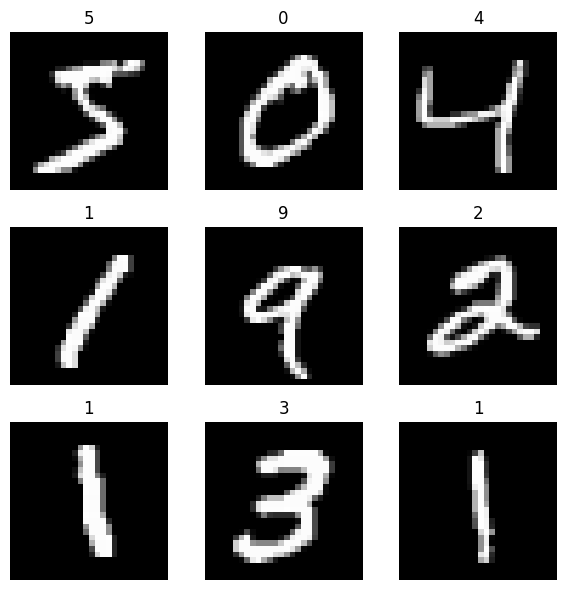

In [ ]:
# Plot 9 images from the train dataset
plt.figure(figsize=(6, 6))
for i, (image, label) in enumerate(zip(train_images, train_labels)):
    if i >= 9:
        break
    plt.subplot(3, 3, i + 1)
    plt.imshow(image, cmap='gray')
    plt.title(label)
    plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip(mode="horizontal", seed=42),
    tf.keras.layers.RandomRotation(factor=0.05, seed=42),
    tf.keras.layers.RandomContrast(factor=0.2, seed=42)
])

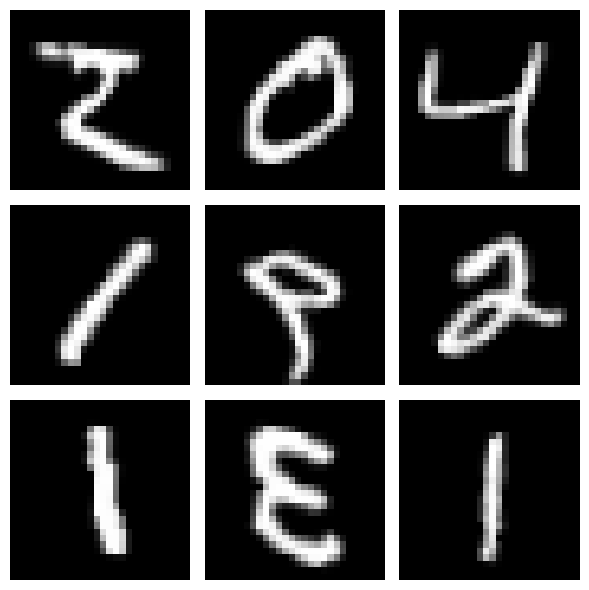

In [ ]:
augmented_train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

# Select a subset of 9 augmented images
augmented_images = []
for image, label in augmented_train_ds.take(9):
    augmented_images.append(tf.squeeze(image))

# Plot the augmented images
plt.figure(figsize=(6, 6))
for i, image in enumerate(augmented_images):
    plt.subplot(3, 3, i + 1)
    plt.imshow(image, cmap='gray')
    plt.axis('off')

plt.tight_layout()
plt.show()

## MLP Mixer

In [ ]:
num_classes = 10
input_shape = (32, 32, 3)

weight_decay = 0.0001
batch_size = 64
num_epochs = 3
dropout_rate = 0.2
image_size = 32  
patch_size = 8  
num_patches = (image_size // patch_size) ** 2 
embedding_dim = 256  
num_blocks = 4  
learning_rate = 0.005

In [ ]:
# Create TensorFlow Datasets from the NumPy arrays
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))

In [ ]:
def transforms(image, label):
    image = tf.image.resize(image, [32, 32])
    image = tf.image.grayscale_to_rgb(image)
    image = image / 255.0
    return image, label

# Apply resizing and channel replication to train dataset
train_ds = train_ds.map(transforms)

# Apply resizing and channel replication to test dataset
test_ds = test_ds.map(transforms)

In [ ]:
class Patches(keras.layers.Layer):
  def __init__(self, patch_size, num_patches):
    super().__init__()
    self.patch_size = patch_size
    self.num_patches = num_patches

  def call(self, images):
    batch_size = tf.shape(images)[0]
    patches = tf.image.extract_patches(
        images=images,
        sizes=[1, self.patch_size, self.patch_size, 1],
        strides=[1, self.patch_size, self.patch_size, 1],
        rates=[1, 1, 1, 1],
        padding="VALID",
    )
    patch_dims = patches.shape[-1]
    patches = tf.reshape(patches, [batch_size, self.num_patches, patch_dims])
    return patches

In [ ]:
# Classifier

def build_classifier(blocks, positional_encoding=False):
    inputs = keras.layers.Input(shape=input_shape)
    
    # Create patches.
    patches = Patches(patch_size, num_patches)(inputs)

    # Encode patches to generate a [batch_size, num_patches, embedding_dim] tensor.
    x = keras.layers.Dense(units=embedding_dim)(patches)

    if positional_encoding:
        positions = tf.range(start=0, limit=num_patches, delta=1)
        position_embedding = keras.layers.Embedding(
            input_dim=num_patches, output_dim=embedding_dim
        )(positions)
        x = x + position_embedding

    x = blocks(x)
    representation = keras.layers.GlobalAveragePooling1D()(x)
    representation = keras.layers.Dropout(rate=dropout_rate)(representation)
    logits = keras.layers.Dense(num_classes)(representation)

    return keras.Model(inputs=inputs, outputs=logits)

In [ ]:
def run_experiment(model):
    optimizer = keras.optimizers.AdamW(learning_rate=learning_rate, weight_decay=weight_decay)
    # Compile the model.
    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="acc"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top5-acc"),
        ],
    )

    # Callbacks
    reduce_lr = keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=5
    )
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=10, restore_best_weights=True
    )

    train_ds_expanded = train_ds.map(lambda x, y: (tf.expand_dims(x, axis=0), y))
    test_ds_expanded = test_ds.map(lambda x, y: (tf.expand_dims(x, axis=0), y))

    history = model.fit(
        train_ds_expanded,
        batch_size=batch_size,
        epochs=num_epochs,
        callbacks=[early_stopping, reduce_lr],
    )

    _, accuracy, top_5_accuracy = model.evaluate(test_ds_expanded)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    # Return history to plot learning curves.
    return history

In [ ]:
class MLPMixerLayer(keras.layers.Layer):
  def __init__(self, num_patches, hidden_units, dropout_rate, *args, **kwargs):
    super().__init__(*args, **kwargs)

    self.mlp1 = keras.Sequential(
        [
            keras.layers.Dense(units=num_patches),
            #keras.tfa.layers.GELU(),
            keras.layers.Dense(units=num_patches),
            keras.layers.Dropout(rate=dropout_rate),
        ]
    )
    self.mlp2 = keras.Sequential(
        [
            keras.layers.Dense(units=num_patches),
            #keras.tfa.layers.GELU(),
            keras.layers.Dense(units=embedding_dim),
            keras.layers.Dropout(rate=dropout_rate),
        ]
    )
    self.normalize = keras.layers.LayerNormalization(epsilon=1e-6)

  def call(self, inputs):
    # Apply layer normalization.
    x = self.normalize(inputs)
    # Transpose inputs from [num_batches, num_patches, hidden_units] to [num_batches, hidden_units, num_patches].
    x_channels = tf.linalg.matrix_transpose(x)
    # Apply mlp1 on each channel independently.
    mlp1_outputs = self.mlp1(x_channels)
    # Transpose mlp1_outputs from [num_batches, hidden_dim, num_patches] to [num_batches, num_patches, hidden_units].
    mlp1_outputs = tf.linalg.matrix_transpose(mlp1_outputs)
    # Add skip connection.
    x = mlp1_outputs + inputs
    # Apply layer normalization.
    x_patches = self.normalize(x)
    # Apply mlp2 on each patch independtenly.
    mlp2_outputs = self.mlp2(x_patches)
    # Add skip connection.
    x = x + mlp2_outputs
    return x